In [2]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid, sub_sample_data

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

In [3]:
def odeFuncI(t,x):
    N = 1000
    S = x[0]
    I = x[1]
    R = x[2]
    beta = 0.2
    r = 0.6
    delta = 0.15
    # theta = np.array([beta, r, delta]) # true parameter settings
    y0 = delta*N - delta*S - beta*I*S  # del S
    y1 = beta*I*S - (r+delta)*I        # del I
    y2 = r*I - delta*R                 # del R
    return y0,y1,y2

In [4]:
def solverFuncI():
    timeVec = np.linspace(0,6,61)
    S_0 = 900
    I_0 = 100
    R_0 = 0
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFuncI,[0,6],x_0,t_eval=timeVec,method='RK45')
    return soln

In [5]:
solnI = solverFuncI()
data1 = np.zeros(61)
stdNoise = 50 
for ii in range (len(data1)):
    data1[ii]=solnI.y[1,ii]+stdNoise*np.random.randn()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
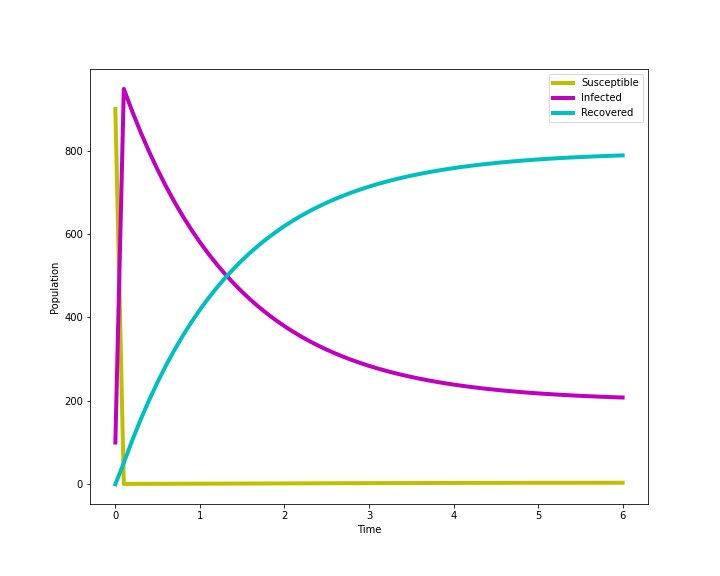

In [6]:
plt.figure(num='Identifiable Version',figsize=(10,8))
plt.plot(solnI.t,solnI.y[0,:],'y',linewidth=4,label='Susceptible')
plt.plot(solnI.t,solnI.y[1,:],'m',linewidth=4,label='Infected')
plt.plot(solnI.t,solnI.y[2,:],'c',linewidth=4,label='Recovered')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
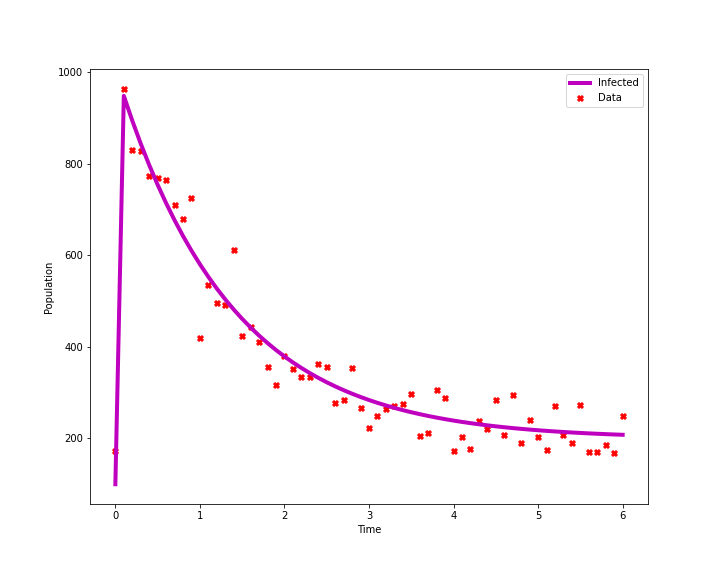

In [7]:
plt.figure(num='Data',figsize=(10,8))
plt.plot(solnI.t,solnI.y[1,:],'m',linewidth=4,label='Infected')
plt.scatter(solnI.t,data1, c='r', marker='X',s=33,label='Data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

In [8]:
def odeFuncU(t,x):
    N = 1000
    S = x[0]
    I = x[1]
    R = x[2]
    gamma = 0.2
    kappa = 0.1
    r = 0.6
    delta = 0.15
    # theta = np.array([gamma, kappa, r, delta]) # true parameter settings
    y0 = delta*N - delta*S - gamma*kappa*I*S  # del S
    y1 = gamma*kappa*I*S - (r+delta)*I        # del I
    y2 = r*I - delta*R                 # del R
    return y0,y1,y2

In [9]:
def solverFuncU():
    timeVec = np.linspace(0,6,61)
    S_0 = 900
    I_0 = 100
    R_0 = 0
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFuncU,[0,6],x_0,t_eval=timeVec,method='RK45')
    return soln

In [10]:
solnU = solverFuncU()
data2 = np.zeros([61,1])
stdNoise = 50
for ii in range (0,len(data2)):
    data2[ii]=solnU.y[1,ii]+stdNoise*np.random.randn()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
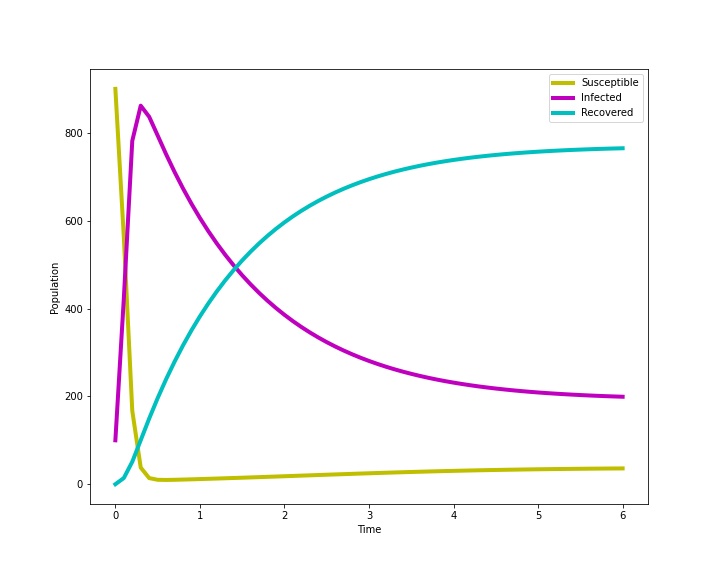

In [11]:
plt.figure(num='Undentifiable Version',figsize=(10,8))
plt.plot(solnU.t,solnU.y[0,:],'y',linewidth=4,label='Susceptible')
plt.plot(solnU.t,solnU.y[1,:],'m',linewidth=4,label='Infected')
plt.plot(solnU.t,solnU.y[2,:],'c',linewidth=4,label='Recovered')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
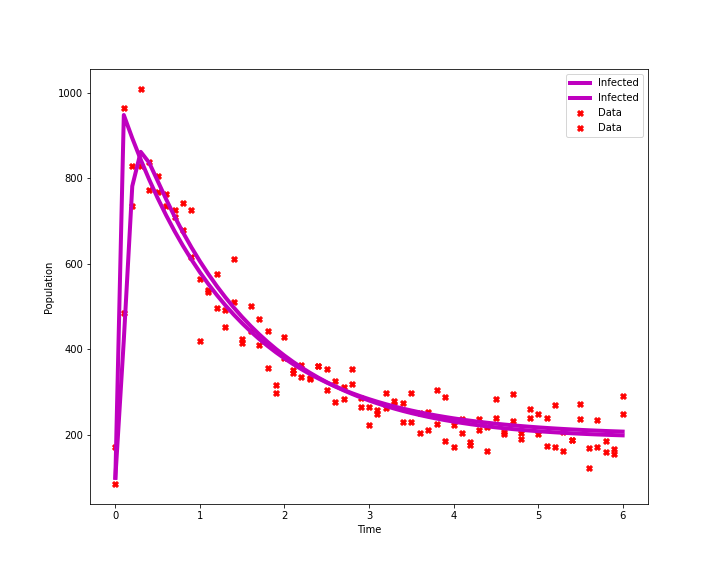

In [12]:
plt.figure(num='Data',figsize=(10,8))
plt.plot(solnU.t,solnU.y[1,:],'m',linewidth=4,label='Infected')
plt.scatter(solnU.t,data2, c='r', marker='X',s=33,label='Data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

In [13]:
    beta = 0.2
    r = 0.6
    delta = 0.15
    theta_t = np.array([beta, r, delta]) # true parameter settings
    #theta = np.random.randn(3)
    print(theta_t)
    gamma = 0.2
    kappa = 0.1
    theta_tU = np.array([gamma, kappa,r, delta]) # true parameter settings
    print(theta_tU)

[0.2  0.6  0.15]
[0.2  0.1  0.6  0.15]


In [14]:
def log_likelihoodI(thetain,data):
    timeVec = np.linspace(0,6,61)
    beta = thetain[0]
    r = thetain[1]
    delta = thetain[2]
    S_0 = 900
    I_0 = 100
    R_0 = 0
    N = 1000
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFuncI, [0,6], y0=x_0, method='RK45', t_eval=timeVec)

#     print(np.round(np.sum(soln.y,axis=0)))
#     if np.any(np.round(np.sum(soln.y,axis=0))!=N):
#         return -np.inf
    if thetain[0] >= 0 and thetain[1] >= 0 and thetain[2] >= 0:
        std = 50
#         pre_exp_term = 1/(np.sqrt(2*np.pi)*std)
#         exp_term = -0.5*np.square((data.T-soln.y[1])/std)
#         f = np.log(pre_exp_term)+exp_term
        f = np.zeros(len(soln.y[1,:]))
        for ii in range(len(soln.y[1,:])):
             f[ii] = np.log(scipy.stats.norm.pdf(data[ii],soln.y[1,ii], std))
        f_theta0 = (np.log(scipy.stats.norm.pdf(thetain[0],0,1)))
        f_theta1 = (np.log(scipy.stats.norm.pdf(thetain[1],0,1)))
        f_theta2 = (np.log(scipy.stats.norm.pdf(thetain[2],0,1)))
        f_theta = np.sum(np.array([f_theta0, f_theta1, f_theta2]))
        out=np.sum(f) + f_theta
        
    else:
        return -np.inf
        

    return out

In [15]:
logpostI = lambda params: log_likelihoodI(params, data1)

In [16]:
def multiVarLogPDF(x,y,cov):
    x_mu = x-y
    logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
    return logpdf

In [17]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                self.num_samples += 1
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                q1 = multiVarLogPDF(y,y2,self.cov)
                q2 = multiVarLogPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
                sampleMeanNew = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                covUpdate     = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - \
                                (ii+1)*np.dot(sampleMeanNew,sampleMeanNew) + \
                                 np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*covUpdate/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sampleMeanNew           
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples, accept / float (self.num_samples)

In [18]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [55]:
num_samples = 10000
dim=3
guess = np.random.randn((dim)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpostI)
# initial_sample = map_point
covin = cov_laplace
print(cov_laplace)
print(map_point)
initial_sample=np.array([0.015, .7, .25])
# initial_sample=theta_t
covin = np.diag(np.array([1e-3, 1e-3, 1e-3]))
covin = np.array([[3.13e-06, -1.3e-05, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04],[-3.9e-06,1.6e-04,9.1e-05]])
print(covin)

data = data1
# dram = DelayedRejectionAdaptiveMetropolis(logpost, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
dram = DelayedRejectionAdaptiveMetropolis(logpostI, covin, freq=5, t0=300, sd = None, eps = 1e-7, max_samples=num_samples)
#dram = DRAM(log_likelihood_I, covin, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)


samples, ar = dram.sample(theta_t,num_samples)
print(samples)



[[1 0 0]
 [0 1 0]
 [0 0 1]]
[-0.59568074 -0.81031658 -1.32725166]
[[ 3.13e-06 -1.30e-05 -3.90e-06]
 [-1.30e-05  5.60e-04  1.60e-04]
 [-3.90e-06  1.60e-04  9.10e-05]]


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2180/2132550020.py:59: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)


Finished sample 1000, acceptance ratio = 0.893
Finished sample 2000, acceptance ratio = 0.8015
Finished sample 3000, acceptance ratio = 0.7363333333333333
Finished sample 4000, acceptance ratio = 0.67625
Finished sample 5000, acceptance ratio = 0.6356
Finished sample 6000, acceptance ratio = 0.6083333333333333
Finished sample 7000, acceptance ratio = 0.5827142857142857
Finished sample 8000, acceptance ratio = 0.56
Finished sample 9000, acceptance ratio = 0.547
[[0.2        0.6        0.15      ]
 [0.19952977 0.61127773 0.14957174]
 [0.19600776 0.60487856 0.13874803]
 ...
 [0.28132764 0.1949509  0.57333408]
 [0.28132764 0.1949509  0.57333408]
 [0.59469795 0.52584834 0.890412  ]]


In [19]:
def sub_sample_data(samples, frac_burn=0.2, frac_use=0.7):
    """Subsample data by burning off the front fraction and using another fraction

    Inputs
    ------
    samples: (N, d) array of samples
    frac_burn: fraction < 1, percentage of samples from the front to ignore
    frac_use: percentage of samples to use after burning, uniformly spaced
    """
    nsamples = samples.shape[0]
    inds = np.arange(nsamples, dtype=np.int)
    start = int(frac_burn * nsamples)
    inds = inds[start:]
    nsamples = nsamples - start
    step = int(nsamples / (nsamples * frac_use))
    inds2 = np.arange(0, nsamples, step)
    inds = inds[inds2]
    return samples[inds, :]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
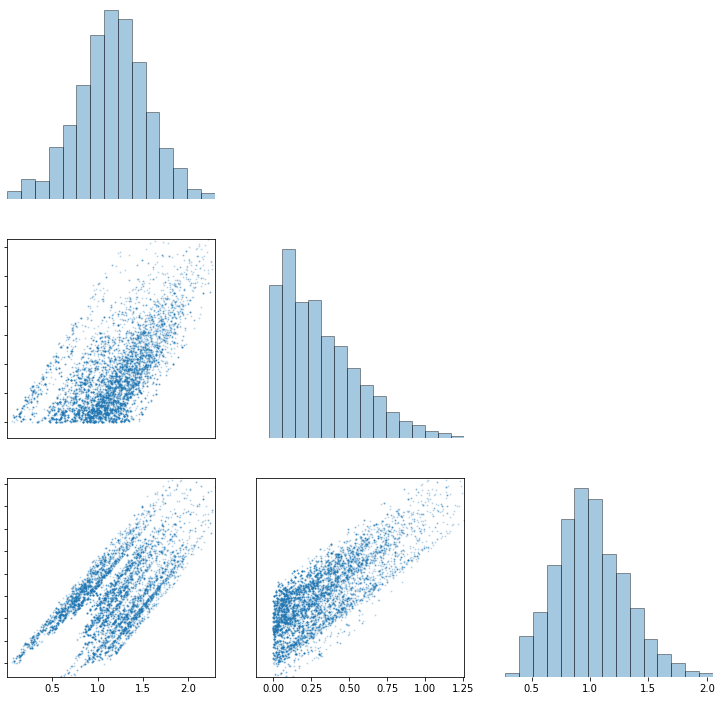

In [56]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)
fig, axs, gs = scatter_matrix([samples_sub], hist_plot=False, gamma=0.2, labels=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$'])
fig.set_size_inches(10,10)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC2 = 1+2*np.sum(autolag[:,2])
print(IAC2)

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_2$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [20]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

In [45]:
def log_likelihoodU(thetain,data):
    timeVec = np.linspace(0,6,61)
    gamma = thetain[0]
    k = thetain[1]
    r = thetain[2]
    delta = thetain[3]
    S_0 = 900
    I_0 = 100
    R_0 = 0
    N = 1000
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFuncU, [0,6], y0=x_0, method='RK45', t_eval=timeVec)

#     print(np.round(np.sum(soln.y,axis=0)))
#     if np.any(np.round(np.sum(soln.y,axis=0))!=N):
#         return -np.inf
    if thetain[0] >= 0 and thetain[1] >= 0 and thetain[2] >= 0 and thetain[3] >= 0:
        std = 50
#         pre_exp_term = 1/(np.sqrt(2*np.pi)*std)
#         exp_term = -0.5*np.square((data.T-soln.y[1])/std)
#         f = np.log(pre_exp_term)+exp_term
#         f = np.zeros(len(soln.y[1,:]))
        for ii in range(len(soln.y[1,:])):
             f[ii] = np.log(scipy.stats.norm.pdf(data[ii], soln.y[1,ii],std))
        f_theta0 = (np.log(scipy.stats.norm.pdf(thetain[0],0,1)))
        f_theta1 = (np.log(scipy.stats.norm.pdf(thetain[1],0,1)))
        f_theta2 = (np.log(scipy.stats.norm.pdf(thetain[2],0,1)))
        f_theta3 = (np.log(scipy.stats.norm.pdf(thetain[3],0,1)))
        f_theta = np.sum(np.array([f_theta0, f_theta1, f_theta2, f_theta3]))
        out=np.sum(f) + f_theta
        
    else:
        return -np.inf
        

    return out

In [46]:
logpostU = lambda params: log_likelihoodU(params, data2)

In [61]:
num_samples = 5000
dim=4
guess = np.random.randn((dim)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpostU)
# initial_sample = map_point
covin = cov_laplace
print(cov_laplace)
print(map_point)
initial_sample=np.array([0.015, 0.015, .7, .25])
# initial_sample=theta_t
# covin = np.diag(np.array([1e-3, 1e-3, 1e-3]))
covin = np.array([[3.13e-06, -1.3e-05, -3.9e-06,9.1e-05],[-1.3e-05, 5.6e-04,1.6e-04,9.1e-05],[-3.9e-06,1.6e-04,9.1e-05,9.1e-05],[-3.9e-06,1.6e-04,9.1e-05,9.1e-05]])
print(covin)

# data = data1
# dram = DelayedRejectionAdaptiveMetropolis(logpost, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
dram = DelayedRejectionAdaptiveMetropolis(logpostU, covin, freq=5, t0=300, sd = None, eps = 1e-7, max_samples=num_samples)
#dram = DRAM(log_likelihood_I, covin, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)


samples, ar = dram.sample(theta_tU,num_samples)
print(samples)




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/optimize.py:809: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[-0.38063704  1.13051718  0.61529057  1.27908954]
[[ 3.13e-06 -1.30e-05 -3.90e-06  9.10e-05]
 [-1.30e-05  5.60e-04  1.60e-04  9.10e-05]
 [-3.90e-06  1.60e-04  9.10e-05  9.10e-05]
 [-3.90e-06  1.60e-04  9.10e-05  9.10e-05]]


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2180/714608849.py:3: RuntimeWarning: invalid value encountered in sqrt
  logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2180/714608849.py:3: RuntimeWarning: overflow encountered in exp
  logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2180/2132550020.py:59: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)


Finished sample 1000, acceptance ratio = 0.77
Finished sample 2000, acceptance ratio = 0.6875
Finished sample 3000, acceptance ratio = 0.652
Finished sample 4000, acceptance ratio = 0.62875
Finished sample 5000, acceptance ratio = 0.6232
Finished sample 6000, acceptance ratio = 0.6186666666666667
Finished sample 7000, acceptance ratio = 0.6135714285714285
Finished sample 8000, acceptance ratio = 0.601875
Finished sample 9000, acceptance ratio = 0.5983333333333334
[[0.2        0.1        0.6        0.15      ]
 [0.19866323 0.13488218 0.60475387 0.15475387]
 [0.19871246 0.16129306 0.60914178 0.15914178]
 ...
 [0.1640507  0.77449175 0.66724244 0.24415858]
 [0.22644834 0.80861589 0.70980956 0.28751193]
 [0.22644834 0.80861589 0.70980956 0.28751193]]


In [ ]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)
fig, axs, gs = scatter_matrix([samples_sub], hist_plot=False, gamma=0.2)
fig.set_size_inches(10,10)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC2 = 1+2*np.sum(autolag[:,2])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,3])
print(IAC3)

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_2$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
axs[3].plot(samples[:, 3], '-k')
axs[3].set_ylabel(r'$x_2$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [24]:
print(data2)


[[  84.92906241]
 [ 484.22141177]
 [ 734.78078996]
 [1008.97967208]
 [ 837.30906543]
 [ 806.21676532]
 [ 735.18694307]
 [ 725.8123022 ]
 [ 742.10525827]
 [ 617.14751717]
 [ 564.4850254 ]
 [ 539.63181349]
 [ 577.1308414 ]
 [ 453.36375384]
 [ 510.73896084]
 [ 415.02757981]
 [ 501.88663654]
 [ 470.97226011]
 [ 443.07260362]
 [ 297.2849105 ]
 [ 429.81964299]
 [ 344.60313456]
 [ 363.58395209]
 [ 330.54251955]
 [ 360.15929481]
 [ 304.59265521]
 [ 326.26432715]
 [ 313.23085855]
 [ 320.29657508]
 [ 286.48182868]
 [ 264.32011474]
 [ 258.48612429]
 [ 297.37655443]
 [ 279.6113464 ]
 [ 231.32913396]
 [ 229.57408467]
 [ 250.56119102]
 [ 252.62603465]
 [ 224.87787097]
 [ 185.64293958]
 [ 224.32207101]
 [ 238.34199199]
 [ 182.6149796 ]
 [ 210.92764399]
 [ 161.75384674]
 [ 239.33472389]
 [ 202.86827418]
 [ 232.63095198]
 [ 203.98895311]
 [ 261.16103668]
 [ 249.67349385]
 [ 240.04892074]
 [ 172.0196879 ]
 [ 162.43157411]
 [ 187.29050726]
 [ 237.70869858]
 [ 123.33695389]
 [ 235.30328897]
 [ 160.6822602

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[9.03263476e-03 2.07939259e-01 2.01428527e-06 1.23654725e+00]
[[ 2.45959944e-01 -2.45959420e-01  8.88188287e-06 -9.97761651e-07]
 [-2.45959420e-01  2.46052368e-01 -2.38757880e-05 -1.06164682e-05]
 [ 8.88188287e-06 -2.38757880e-05  6.35464196e-04  3.72044182e-04]
 [-9.97761651e-07 -1.06164682e-05  3.72044182e-04  3.17570091e-04]]


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_3162/1036200718.py:60: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)
/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_3162/1036200718.py:54: RuntimeWarning: overflow encountered in exp
  a1y2y1 = np.exp(y_logpdf-y_logpdf2)


Finished sample 1000, acceptance ratio = 0.0015
Finished sample 2000, acceptance ratio = 0.001
Finished sample 3000, acceptance ratio = 0.0015005001667222407
Finished sample 4000, acceptance ratio = 0.0013753438359589898


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_3162/3464279978.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inds = np.arange(nsamples, dtype=np.int)


Accepted Sample Ration for 3.1: 0.0011004401760704283


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
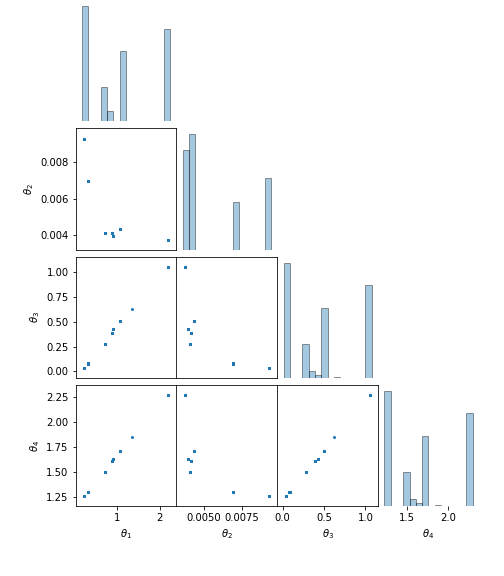

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
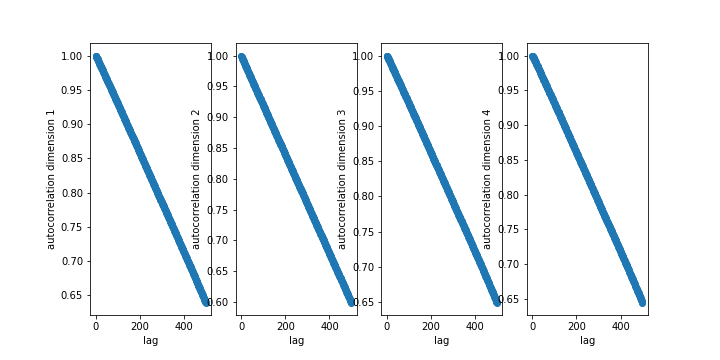

822.6581310812842
800.0264288382025
827.7882890035003
825.7368138544249


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
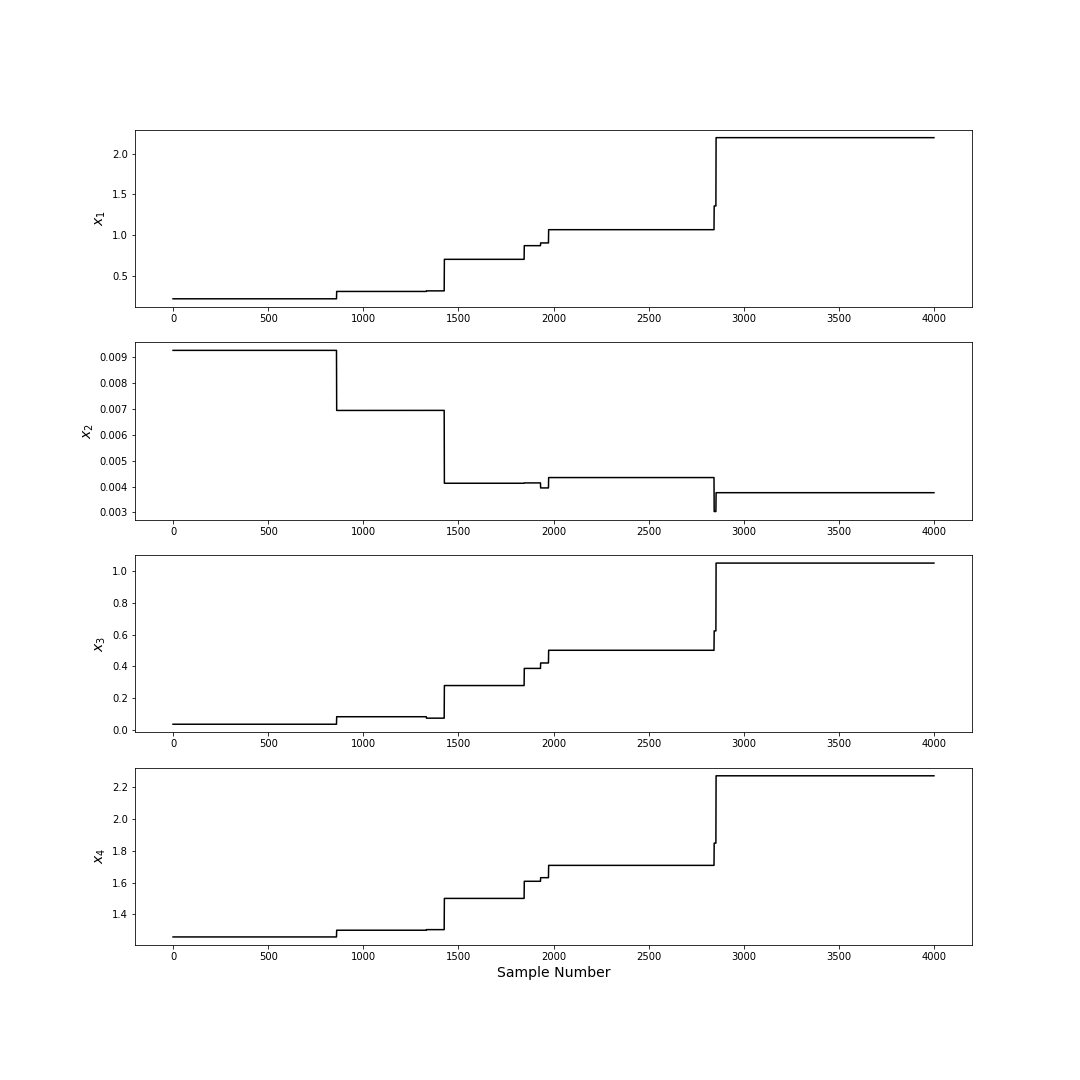

In [27]:
def logpdf_SIR_NI(theta):

    def SIRmodel_NI(t, x):
        S, I, R = x
        N=1000
        gamma, beta, r, delta = theta
        SIRout = [delta*N-delta*S-gamma*beta*I*S, gamma*beta*I*S-(r+delta)*I, r*I - delta*R]
        return SIRout
    
    sol = scipy.integrate.solve_ivp(SIRmodel_NI, [0, 6], [900, 100, 0], t_eval = np.linspace(0,6,61))
    
    ypdf = np.zeros(len(sol.y[1,:]))
    tpdf = np.zeros(4)
    
    if theta[0] >= 0 and theta[1] >= 0 and theta[2] >= 0 and theta[3] >= 0:
        for ii in range(len(sol.y[1,:])):
             ypdf[ii] = np.log(scipy.stats.norm.pdf(sol.y[1,ii],data2[ii], 50))
             #ypdf[ii] = np.log((1/(50*np.sqrt(2*np.pi)))*np.exp((-1/2)*np.square((Inoise[ii] - sol.y[1,ii])/50)))
            
        for jj in range(4):
             tpdf[jj] = np.log(scipy.stats.norm.pdf(theta[jj],0,1))
        
        #print(ypdf)
        return np.sum(tpdf) + np.sum(ypdf)
    else:
        return -np.inf
#%%
num_samples = 5000
theta_initial = np.array([0.01, 0.1, 0.1, 0.1])
theta_initial, cov_initial = laplace_approx(theta_initial, logpdf_SIR_NI)
cov_initial=np.array([[ 2.45959944e-01, -2.45959420e-01,  8.88188287e-06, -9.97761651e-07],
 [-2.45959420e-01,  2.46052368e-01, -2.38757880e-05, -1.06164682e-05],
 [ 8.88188287e-06, -2.38757880e-05,  6.35464196e-04,  3.72044182e-04],
 [-9.97761651e-07, -1.06164682e-05 , 3.72044182e-04,  3.17570091e-04]])

print(theta_initial)
print(cov_initial)
#%%
dram = DelayedRejectionAdaptiveMetropolis(logpdf_SIR_NI, cov_initial, max_samples=num_samples)
samples, ar = dram.sample(theta_initial, num_samples)
samples_sub = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)
print(f"Accepted Sample Ration for 3.1: {ar}")
#%%
fig, axs, gs = scatter_matrix([samples_sub], labels=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$'], 
                              hist_plot=False, gamma=0.9,
                                 nbins=70)
fig.set_size_inches(7,8)
plt.show()
    
fig, axs = plt.subplots(4,1, figsize=(15,15))
# fig.suptitle('Delayed Rejection Metropolis', fontsize=16)
axs[0].plot(samples_sub[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples_sub[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[2].plot(samples_sub[:, 2], '-k')
axs[2].set_ylabel(r'$x_3$', fontsize=14)
axs[3].plot(samples_sub[:, 3], '-k')
axs[3].set_ylabel(r'$x_4$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)

maxlag=500
step=1
lags, autolag = autocorrelation(samples_sub, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation dimension 3')
axs[3].plot(lags, autolag[:, 3],'-o')
axs[3].set_xlabel('lag')
axs[3].set_ylabel('autocorrelation dimension 4')
# fig.suptitle('Delayed Rejection Adaptive Metropolis', fontsize=16)
plt.show()

# j = integrated_autocorrelation(autolag)
# print(f"The integrated autocorrelation for DRAM: {j}")
# print(f"Mean of Theta: {np.array([np.mean(samples_sub[:, 0]), np.mean(samples_sub[:, 1]), np.mean(samples_sub[:, 2]), np.mean(samples_sub[:, 3])])}")

IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC2 = 1+2*np.sum(autolag[:,2])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,3])
print(IAC3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
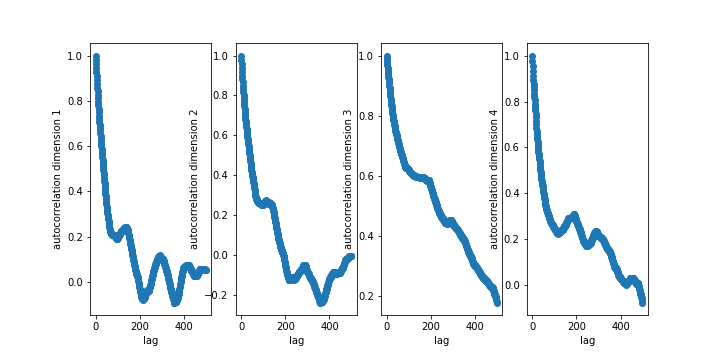

In [79]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples_sub, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation dimension 3')
axs[3].plot(lags, autolag[:, 3],'-o')
axs[3].set_xlabel('lag')
axs[3].set_ylabel('autocorrelation dimension 4')
# fig.suptitle('Delayed Rejection Adaptive Metropolis', fontsize=16)
plt.show()

In [84]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC2 = 1+2*np.sum(autolag[:,2])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,3])
print(IAC3)

148.2136847489569
230.4140967892326
405.7119582741493
199.58654077407746


/Users/dedo/Documents/okul/AEROSP567/project/2b/mcmc_utils_and_plot.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
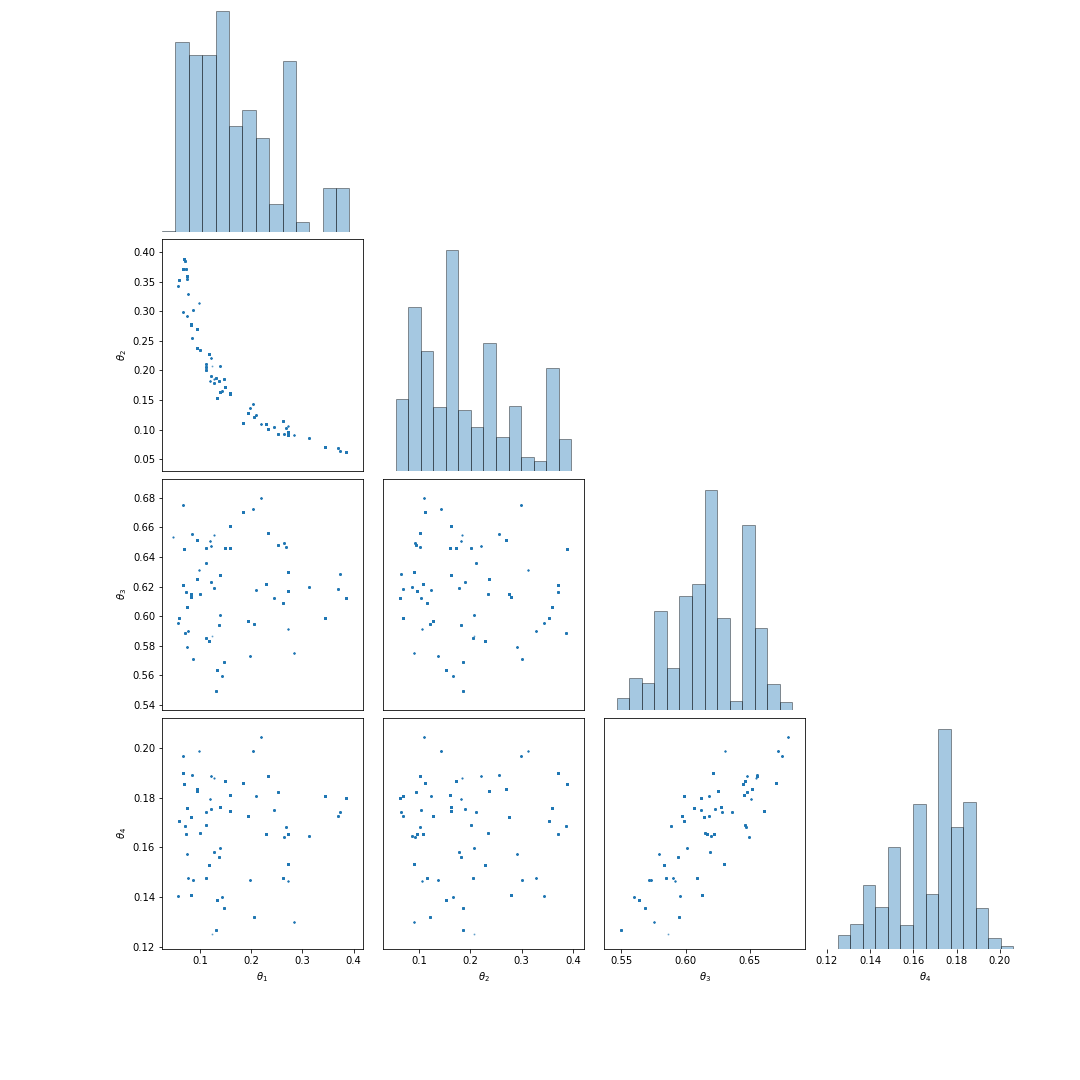

In [81]:
fig, axs, gs = scatter_matrix([samples_sub], labels=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$'], 
                              hist_plot=False, gamma=0.5,
                                 nbins=70)
fig.set_size_inches(15,15)
plt.show()

Text(0.5, 0, 'Sample Number')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
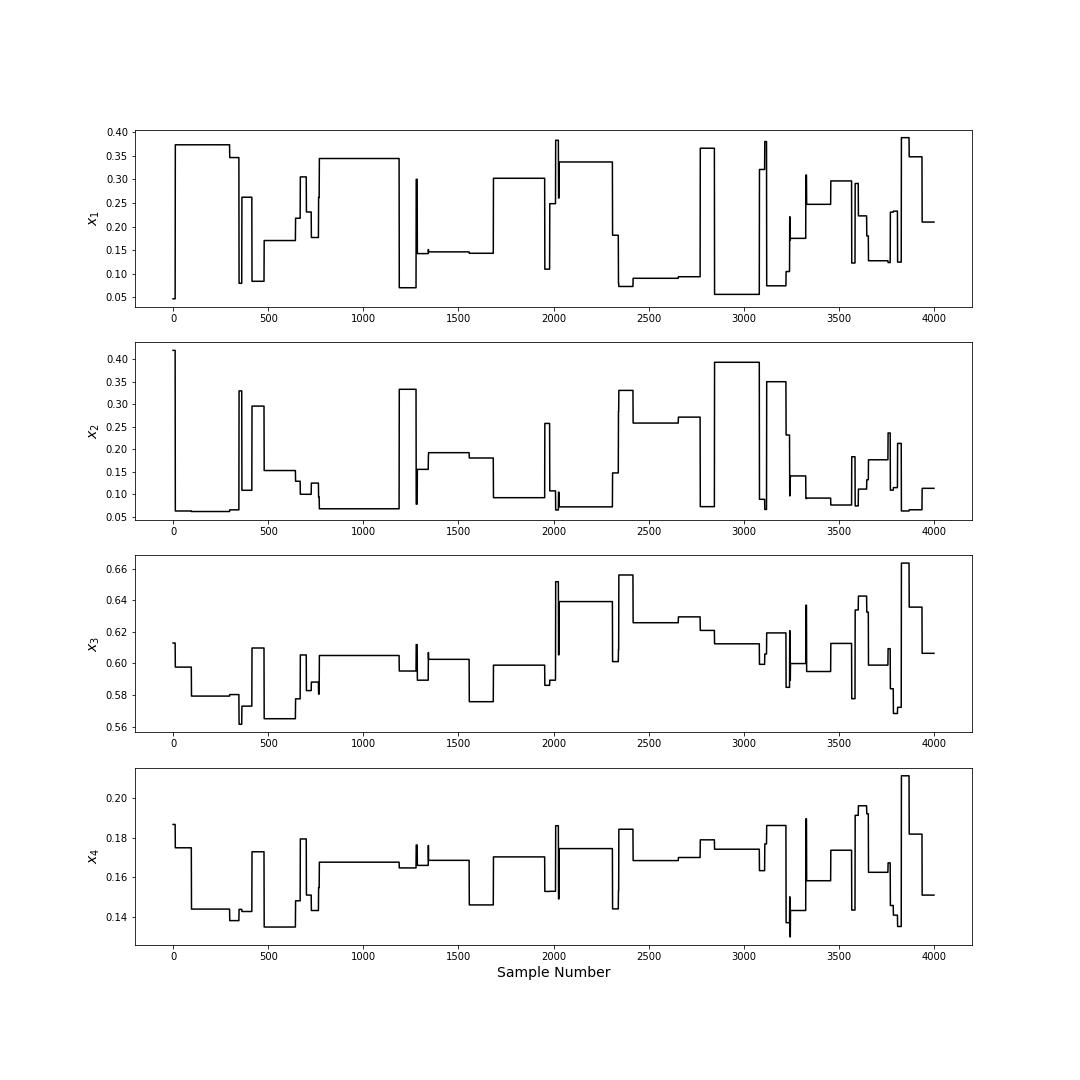

In [83]:
fig, axs = plt.subplots(4,1, figsize=(15,15))
# fig.suptitle('Delayed Rejection Metropolis', fontsize=16)
axs[0].plot(samples_sub[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples_sub[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[2].plot(samples_sub[:, 2], '-k')
axs[2].set_ylabel(r'$x_3$', fontsize=14)
axs[3].plot(samples_sub[:, 3], '-k')
axs[3].set_ylabel(r'$x_4$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)